# Download Dataset

In [ ]:
# !wget http://www.vision.caltech.edu/Image_Datasets/faces/faces.tar

In [ ]:
# !mkdir faces
# !tar -xvf faces.tar -C ./faces

In [ ]:
from PIL import Image
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
from sklearn import manifold
from facenet_pytorch import MTCNN, InceptionResnetV1


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
mat = scipy.io.loadmat('./faces/ImageData.mat')['SubDir_Data'].T
mat.shape

(450, 8)

# EDA

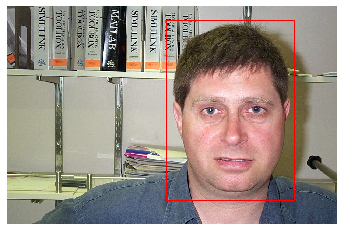

In [ ]:
fig, ax = plt.subplots(1)
img = Image.open(r"./faces/image_0001.jpg") 
ax.imshow(img)
xl, yb, xr, yt = mat[0][0], mat[0][1],mat[0][4], mat[0][5]
w, h = xr - xl, yt - yb
rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
ax.add_patch(rect)
plt.axis('off')
plt.show()

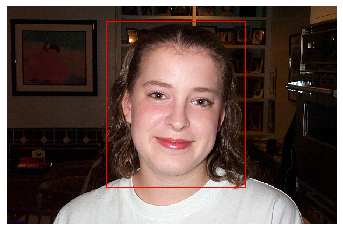

In [ ]:
fig, ax = plt.subplots(1)
img = Image.open(r"./faces/image_0365.jpg") 
ax.imshow(img)
xl, yb, xr, yt = mat[364][0], mat[364][1],mat[364][4], mat[364][5]
w, h = xr - xl, yt - yb
rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
ax.add_patch(rect)
plt.axis('off')
plt.show()

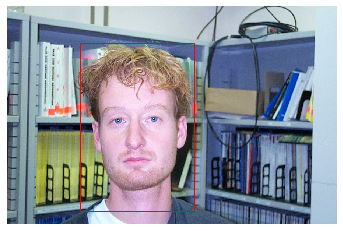

In [ ]:
fig, ax = plt.subplots(1)
img = Image.open(r"./faces/image_0257.jpg") 
ax.imshow(img)
xl, yb, xr, yt = mat[256][0], mat[256][1],mat[256][4], mat[256][5]
w, h = xr - xl, yt - yb
rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
ax.add_patch(rect)
plt.axis('off')
plt.show()

# Clustering

In [ ]:
# model = nn.DataParallel(models.resnet50(pretrained=True).to(device))
model = nn.DataParallel(InceptionResnetV1(pretrained='casia-webface')).eval()
model.to(device)

DataParallel(
  (module): InceptionResnetV1(
    (conv2d_1a): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2a): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (conv2d_2b): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2d_3b): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, 

In [ ]:
import glob
g = glob.glob("./faces/*.jpg")
g.sort()
image_list = []
for n in range(len(g)):
    img = Image.open(g[n]).convert('RGB')
    img = img.resize((224,224))
    image_list.append(img)


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))])

In [ ]:
class Faces(Dataset):
    def __init__(self, g, mat, transform=None):
        super().__init__()
        self.g = g
        self.mat = mat
        self.transform = transform
    
    def __len__(self):
        return len(self.g)
    
    def __getitem__(self,item):
        img = Image.open(self.g[item]).convert('RGB')
        
        bbox = torch.from_numpy(self.mat[item].astype('int32'))
        
        if self.transform is not None:
            img = self.transform(img)
        
        img_crop = torch.nn.functional.interpolate(img[:, bbox[5]:bbox[0], bbox[0]:bbox[4]].unsqueeze(0), (224, 224)).squeeze()
        img = torch.nn.functional.interpolate(img.unsqueeze(0),(224,224)).squeeze()
        return {'image' : img, 'bbox' : bbox, 'crop' : img_crop}

In [ ]:
data = Faces(g, mat, transform)
len(data)
batch_size = 50

In [ ]:
data_loader = torch.utils.data.DataLoader(data,batch_size=batch_size,shuffle=False)

In [ ]:
image_emb=[]
for i,batch in enumerate(data_loader):
    print("Batch: ", i)
    img_crop = batch['crop'].to(device)
    emb = model(img_crop).detach().cpu().numpy()
    image_emb.append(emb)


Batch:  0
Batch:  1
Batch:  2
Batch:  3
Batch:  4
Batch:  5
Batch:  6
Batch:  7
Batch:  8


In [ ]:
image_emb = np.concatenate(image_emb)

/home/nivedita.rufus/intelpython3/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


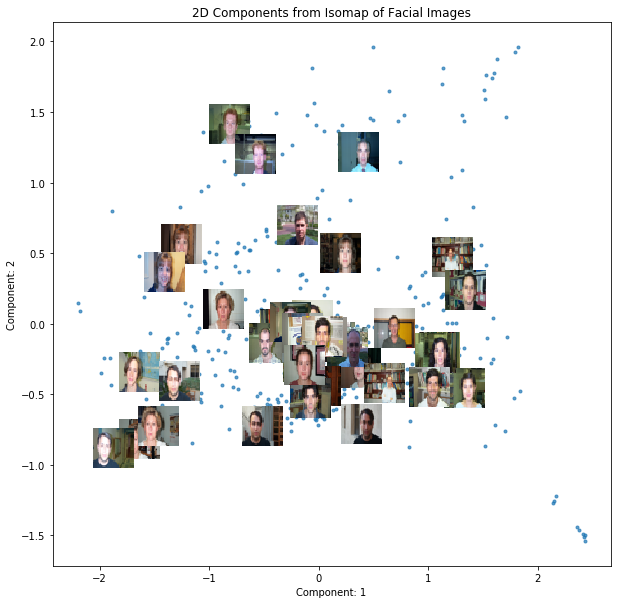

In [ ]:
iso = manifold.Isomap(n_neighbors=6, n_components=2)
iso.fit(image_emb)
manifold_2Da = iso.transform(image_emb)
manifold_2D = pd.DataFrame(manifold_2Da, columns=['Component 1', 'Component 2'])
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111)
ax.set_title('2D Components from Isomap of Facial Images')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')
x_size = (max(manifold_2D['Component 1']) - min(manifold_2D['Component 1'])) * 0.08
y_size = (max(manifold_2D['Component 2']) - min(manifold_2D['Component 2'])) * 0.08
for i in range(40):
    img_num = np.random.randint(0, image_emb.shape[0])
    x0 = manifold_2D.loc[img_num, 'Component 1'] - (x_size / 2.)
    y0 = manifold_2D.loc[img_num, 'Component 2'] - (y_size / 2.)
    x1 = manifold_2D.loc[img_num, 'Component 1'] + (x_size / 2.)
    y1 = manifold_2D.loc[img_num, 'Component 2'] + (y_size / 2.)
    img = image_list[img_num].resize((32, 32))
    ax.imshow(img, aspect='auto', cmap=plt.cm.gray, 
              interpolation='nearest', zorder=100000, extent=(x0, x1, y0, y1))

ax.scatter(manifold_2D['Component 1'], manifold_2D['Component 2'], marker='.',alpha=0.7)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=27, init='k-means++', max_iter=300, n_init=10, random_state=0)

In [ ]:
label = kmeans.fit_predict(image_emb)
u_labels = np.unique(label)


(-0.5, 223.5, 223.5, -0.5)

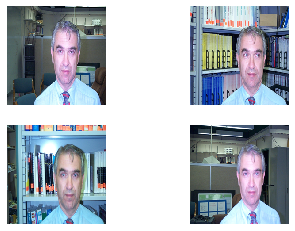

In [ ]:
idxs = np.where(label == 16)[0]
faces=[]
for i in idxs:
    face = image_list[i]
    faces.append(face)
figure, axis = plt.subplots(2, 2)
axis[0, 0].imshow(faces[1])
axis[0, 0].axis('off')  
axis[0, 1].imshow(faces[2])
axis[0, 1].axis('off')  
axis[1, 0].imshow(faces[3])
axis[1, 0].axis('off')
axis[1, 1].imshow(faces[4])
axis[1, 1].axis('off')


(-0.5, 223.5, 223.5, -0.5)

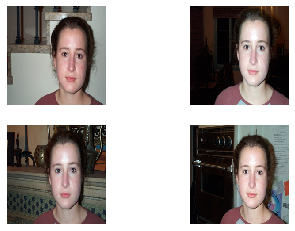

In [ ]:
idxs = np.where(label == 5)[0]
faces=[]
for i in idxs:
    face = image_list[i]
    faces.append(face)
figure, axis = plt.subplots(2, 2)
axis[0, 0].imshow(faces[1])
axis[0, 0].axis('off')  
axis[0, 1].imshow(faces[2])
axis[0, 1].axis('off')  
axis[1, 0].imshow(faces[3])
axis[1, 0].axis('off')
axis[1, 1].imshow(faces[4])
axis[1, 1].axis('off')


(-0.5, 223.5, 223.5, -0.5)

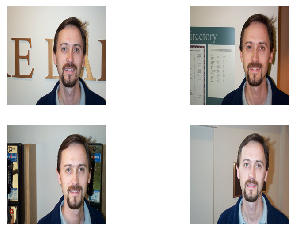

In [ ]:
idxs = np.where(label == 18)[0]
faces=[]
for i in idxs:
    face = image_list[i]
    faces.append(face)
figure, axis = plt.subplots(2, 2)
axis[0, 0].imshow(faces[1])
axis[0, 0].axis('off')  
axis[0, 1].imshow(faces[2])
axis[0, 1].axis('off')  
axis[1, 0].imshow(faces[3])
axis[1, 0].axis('off')
axis[1, 1].imshow(faces[4])
axis[1, 1].axis('off')
